In [1]:
import os
import gzip
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

# Preparing dataset

First example is number 5


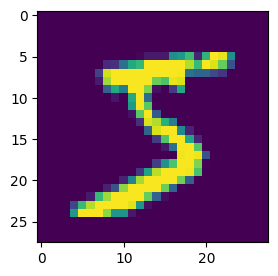

In [2]:
def prepare_mnist(path='mnist_data'):
  base_url = 'http://yann.lecun.com/exdb/mnist/'
  files = [
      'train-images-idx3-ubyte.gz',
      'train-labels-idx1-ubyte.gz',
      't10k-images-idx3-ubyte.gz',
      't10k-labels-idx1-ubyte.gz'
  ]

  if not os.path.exists(path):
      os.makedirs(path)

  for file in files:
    if not os.path.exists(os.path.join(path, file)):
      urllib.request.urlretrieve(base_url + file, os.path.join(path, file))

  def load_image(filename, offset):
    with gzip.open(filename, 'rb') as f:
      data = np.frombuffer(f.read(), np.uint8, offset=offset)
    return data

  X = load_image(f'{path}/train-images-idx3-ubyte.gz', 16).reshape(-1, 28, 28)
  y = load_image(f'{path}/train-labels-idx1-ubyte.gz', 8)
  X_test = load_image(f'{path}/t10k-images-idx3-ubyte.gz', 16).reshape(-1, 28, 28)
  y_test = load_image(f'{path}/t10k-labels-idx1-ubyte.gz', 8)

  # plot the first example image
  print(f"First example is number {y[0]}")
  plt.figure(figsize=(3, 3))
  plt.imshow(X[0])
  return X, y, X_test, y_test

X, y, X_test, y_test = prepare_mnist()

In [3]:
# split to traning and dev set (50 000 train, 10 000 dev and 10 000 test set)
split_idx = 50000
seed = 42
np.random.seed(seed)
idxs = np.arange(X.shape[0])
np.random.shuffle(idxs)
X, y = X[idxs], y[idxs]
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

# convert to pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 28*28)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 28*28)
y_val = torch.tensor(y_val, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 28*28)
y_test = torch.tensor(y_test, dtype=torch.int64)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

# PyTorch modeling

In [4]:
# hyperparameters
input_dim = 28*28
output_dim = 10
hidden_dim = 512
lr = 0.001
epochs = 1000
batch_size = 64

In [24]:
class SimpleNeural_network(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(SimpleNeural_network, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [25]:
model = SimpleNeural_network(input_dim, hidden_dim, output_dim)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# training loop
for epoch in range(epochs):
  # mini-batch
  ixs = np.random.randint(X_train.shape[0], size=batch_size)
  xs = X_train[ixs]
  ys = y_train[ixs]
  
  # reset the gradient
  optimizer.zero_grad()
  
  # forward pass
  probs = model(xs)
  loss = criterion(probs, ys)
  accuracy = (torch.argmax(probs, dim=1) == ys).float().mean()
  
  # bacward pass
  loss.backward()
  optimizer.step()
  
  # validation
  with torch.no_grad():
    val_probs = model(X_val)
    val_loss = criterion(val_probs, y_val)
    val_accuracy = (torch.argmax(val_probs, dim=1) == y_val).float().mean()
  
  # print logs
  if epoch % 50 == 0:
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}, \
Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy.item():.4f}")


Epoch [1/1000], Loss: 34.8590, Accuracy: 0.1250, Val Loss: 58.3320, Val Accuracy: 0.2129
Epoch [51/1000], Loss: 0.8682, Accuracy: 0.8438, Val Loss: 1.1276, Val Accuracy: 0.8498
Epoch [101/1000], Loss: 0.7581, Accuracy: 0.8594, Val Loss: 0.8505, Val Accuracy: 0.8749
Epoch [151/1000], Loss: 0.8916, Accuracy: 0.9062, Val Loss: 0.7269, Val Accuracy: 0.8766
Epoch [201/1000], Loss: 1.0468, Accuracy: 0.8594, Val Loss: 0.5615, Val Accuracy: 0.8982
Epoch [251/1000], Loss: 0.1173, Accuracy: 0.9688, Val Loss: 0.4832, Val Accuracy: 0.9066
Epoch [301/1000], Loss: 0.3875, Accuracy: 0.8906, Val Loss: 0.4458, Val Accuracy: 0.9126
Epoch [351/1000], Loss: 0.6689, Accuracy: 0.9062, Val Loss: 0.4245, Val Accuracy: 0.9124
Epoch [401/1000], Loss: 0.1523, Accuracy: 0.9219, Val Loss: 0.3934, Val Accuracy: 0.9161
Epoch [451/1000], Loss: 0.2082, Accuracy: 0.9375, Val Loss: 0.4002, Val Accuracy: 0.9157
Epoch [501/1000], Loss: 0.4842, Accuracy: 0.8906, Val Loss: 0.3723, Val Accuracy: 0.9171
Epoch [551/1000], Loss

Most predicted:  6
Less predicted:  1
Ground truth:    6


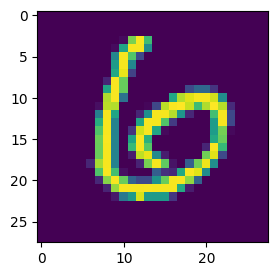

In [26]:
exm = 11
plt.figure(figsize=(3, 3))
plt.imshow(X_test[exm].reshape(28, 28))
print("Most predicted: ", torch.argmax(model(X_test[exm].reshape(1, -1))).item())
print("Less predicted: ", torch.argmin(model(X_test[exm].reshape(1, -1))).item())
print("Ground truth:   ", y_test[exm].item())

In [201]:
# accuracy and loss on the test set 
test_preds = model(X_test)
test_loss = criterion(test_preds, y_test)
test_accuracy = (torch.argmax(test_preds, dim=1) == y_test).float().mean()
print(f"{test_loss=}")
print(f"{test_accuracy=}")

test_loss=tensor(0.2398, grad_fn=<NllLossBackward0>)
test_accuracy=tensor(0.9381)


In [202]:
# accuracy and loss on the train set 
train_preds = model(X_train)
train_loss = criterion(train_preds, y_train)
train_accuracy = (torch.argmax(train_preds, dim=1) == y_train).float().mean()
print(f"{train_loss=}")
print(f"{train_accuracy=}")

train_loss=tensor(0.1578, grad_fn=<NllLossBackward0>)
train_accuracy=tensor(0.9589)


In [203]:
model(X_test[exm].reshape(1, -1)).reshape(-1).detach().numpy()

array([-1.8221645e+01, -2.3161549e+01, -1.4088332e+01, -1.6089018e+01,
       -1.3256840e+01, -1.5351544e+01, -1.5735503e-05, -1.1496009e+01,
       -1.2843336e+01, -1.6220480e+01], dtype=float32)

# Visualization

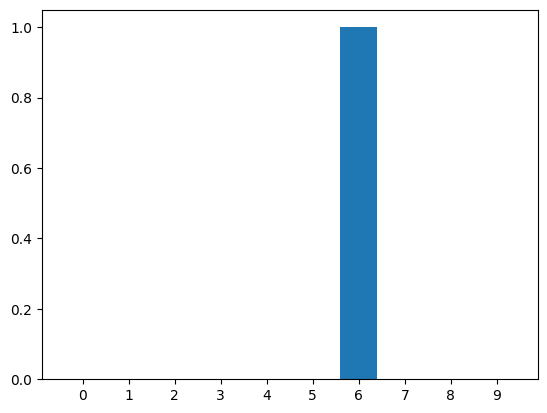

In [204]:
plt.bar(range(0, 10), np.exp(model(X_test[exm].reshape(1, -1)).reshape(-1).detach().numpy()));
plt.xticks(range(0, 10));

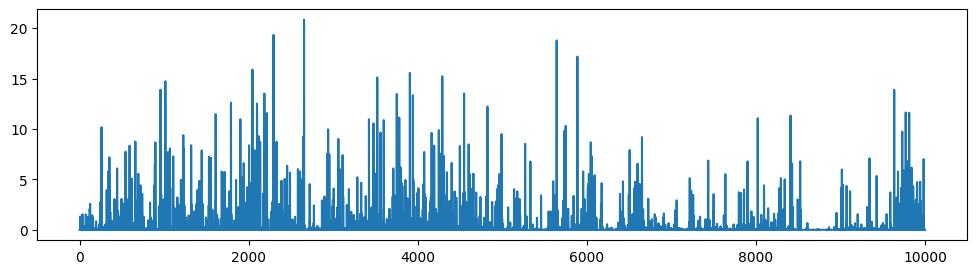

In [208]:
# calculating the uncertainity
                    # forward pass probs                   # ground truth                   # for all xs
losses = [criterion(model(X_test[i].reshape(1, -1)), y_test[i].reshape(1)).item() for i in range(X_test.shape[0])]
losses = np.array(losses)
plt.figure(figsize=(12, 3))
plt.plot(losses);

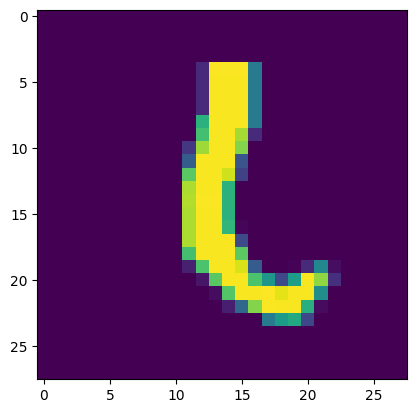

In [209]:
# most "uncertained" picture
plt.imshow(X_test[np.argmax(losses)].reshape(28, 28));

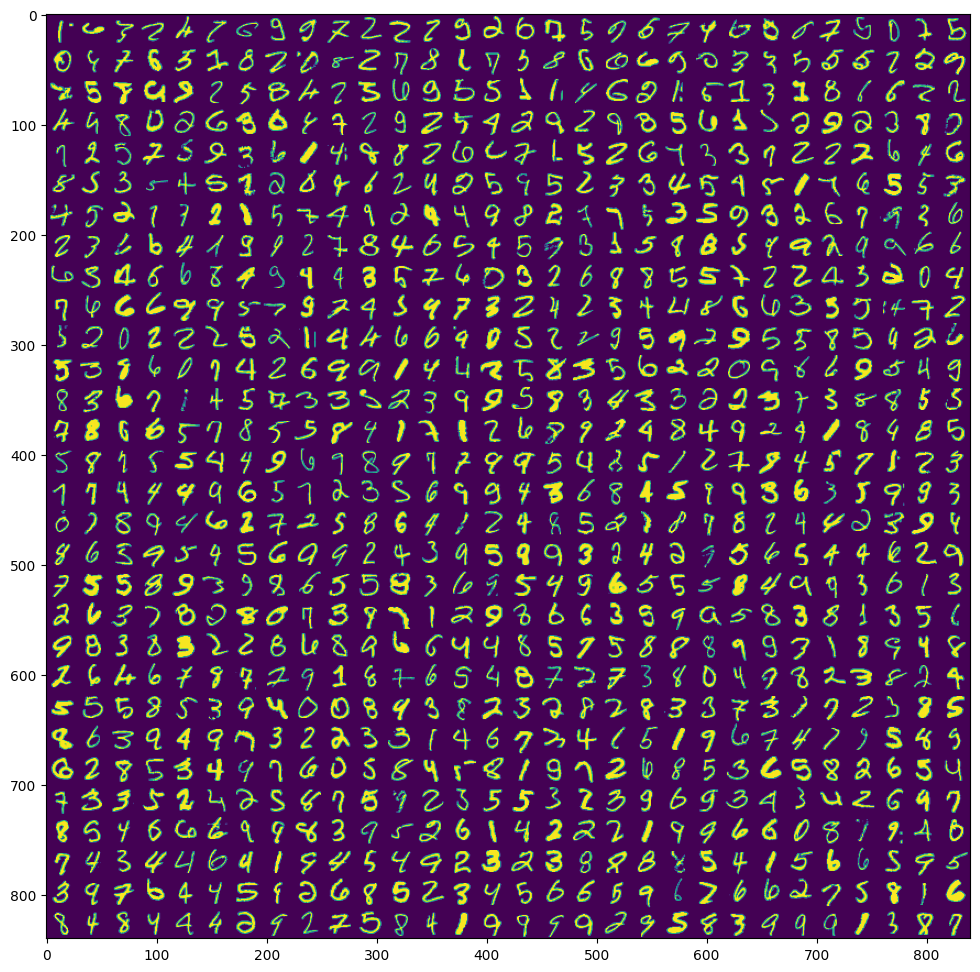

In [483]:
# computational power huh :D
N = 30
# array[-N*N:] --> equivalent to the --> array[::-1][:N*N]
idxs = np.argsort(losses)[::-1][:N*N] # first N uncertain images
# to see least uncertain images, delete `[::-1]`
images = [X_test[i].reshape(28, 28) for i in idxs] # reshape each img to 28x28
grid = np.concatenate(
  [np.concatenate(images[i*N : (i+1)*N], axis=1) for i in range(N)], # concat cols
  axis=0                                                             # concat rows
)
plt.figure(figsize=(12, 12))
plt.imshow(grid);

# NumPy only

In [25]:
# convert back to numpy ndarray
X_test = X_test.numpy()
y_test = y_test.numpy()
X_train = X_train.numpy()
y_train = y_train.numpy()

In [29]:
# forward pass in numpy
def forward():
  # copying the weights from pytorch
  fc1 = model.fc1.weight.detach().numpy().T
  fc2 = model.fc2.weight.detach().numpy().T
  z1 = X_test @ fc1 # first pre activation
  a1 = np.maximum(0, z1) # relu activation
  z2 = a1 @ fc2 # second hidden layer
  # apply log softmax
  exps = np.exp(z2 - z2.max(axis=1, keepdims=True)) # prevent overflow
  softmax = exps / np.sum(exps, axis=1, keepdims=True) # normalize
  log_softmax = np.log(softmax) # apply natural logarithm
  return log_softmax

log_softmax = forward()

In [30]:
# numpy and torch accuracy matches
# pytorch loss     --> 0.2508
# pytorch accuracy --> 0.9389
np_loss = -log_softmax[np.arange(log_softmax.shape[0]), y_test].mean()
np_accuracy = (np.argmax(log_softmax, axis=1) == y_test).astype(np.float32).mean()
print(f"{np_accuracy=:.4f}")
print(f"{np_loss=:.4}")

np_accuracy=0.9425
np_loss=0.2411


In [31]:
# we dont have biases for numpy model yet

In [32]:
# now real challenge :D, do the backprop with numpy only

<details>
<summary><b>Forward pass notes</b></summary>

```python
z = X_train @ W1 # first pre activation
a = np.maximum(0, z) # relu activation
logits = a @ W2 # second hidden layer
# apply log softmax
logit_maxs = np.max(logits, axis=1, keepdims=True)
norm_logits = logits - logit_maxs # prevent the overflow and infs
counts = np.exp(norm_logits)
counts_sum = np.sum(counts, axis=1, keepdims=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = np.log(probs)
loss = -logprobs[range(n), y_train].mean()
accuracy = (np.argmax(logprobs, axis=1) == y_train).astype(float).mean()
print(f"{loss=}, {accuracy=}")
```
</details>



<details>
<summary><b>Backard pass notes</b></summary>

```python
dloss = 1
# loss = -logprobs[range(n), y_train].mean()
# d = -(a + b + c) / 3
# dd/da = -1/3
dlogprobs = np.zeros_like(logprobs) * dloss
dlogprobs[range(n), y_train] = -1.0 / n
assert dlogprobs.shape == logprobs.shape
# y = log(x)  --> dy/dx = 1/x
dprobs = (1.0 / probs) * dlogprobs
assert dprobs.shape == probs.shape
# counts * counts_sum_inv  --> (50000, 10) * (50000, 1) = (50000, 10)
# here there is an implicit broadcasting, so we have to take that into account as well. Toy example:
# c = a * b, but with tensors:
# a[3x3] * b[3,1]| --->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# c [3x3]|
# there is two operation, first is replication and second is multiplication (vice versa in the code below)
dcounts_sum_inv = (counts * dprobs).sum(axis=1, keepdims=True)
assert dcounts_sum_inv.shape == counts_sum_inv.shape
dcounts = counts_sum_inv * dprobs # ??? why not sum here, also not final derivative
assert dcounts.shape == counts.shape
dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
assert dcounts_sum.shape == counts_sum_inv.shape # d(x**-1) = -x**-2
# np.sum(counts, axis=1, keepdims=True)
# toy example
# a11 a12 a13 b1 (= a11 + a12 + a13)
# a21 a22 a23 b2 (= a21 + a22 + a23)
# a31 a32 a33 b3 (= a31 + a32 + a33)
dcounts += np.ones_like(counts) * dcounts_sum # note the "+=" because it has two branches
assert dcounts.shape == counts.shape
dnorm_logits = counts * dcounts # counts = np.exp(norm_logits) --> de**x = e**x
assert dnorm_logits.shape == norm_logits.shape
# logits - logit_maxs
# toy example
# c11 c12 c13 = all a12 a13 - b1
# c21 c22 c23 = a21 a22 a23 - b2
# c31 c32 c33 = a31 a32 a33 - b3
# so e.g. c32 = a32 - b3
dlogits = dnorm_logits.copy() # not final derivative
dlogit_maxs = (-dnorm_logits).sum(axis=1, keepdims=True)
assert dlogit_maxs.shape == logit_maxs.shape
# pytorch --> dlogits += F.one_hot(logits.max(1) indices, num_classes=logits.shape[1]) * dlogit_maxes
one_hot = np.eye(logits.shape[1])[np.argmax(logits, axis=1)] # second part is indices
dlogits += one_hot * dlogit_maxs # note the "+=" because there was previous branch
assert dlogits.shape == logits.shape
da = dlogits @ W2.T
assert da.shape == a.shape
dW2 = a.T @ dlogits
assert dW2.shape == W2.shape
dz = (a > 0).astype(float) * da
assert dz.shape == z.shape
dW1 = X_train.T @ dz
assert dW1.shape == dW1.shape
```
</details>


In [5]:
# copying the weights from pytorch
W1 = model.fc1.weight.detach().numpy().T
W2 = model.fc2.weight.detach().numpy().T

NameError: name 'model' is not defined

In [58]:
# initialization matters!
# learn initializations, essentially how do we scale the random weights?

def init_layers(input_dim, hidden_dim, output_dim, distribution):
  if distribution == 'gaussian':
    W1 = np.random.randn(input_dim, hidden_dim)
    W2 = np.random.randn(hidden_dim, output_dim)
  elif distribution == 'uniform':
    W1 = np.random.uniform(-1., 1., size=(input_dim, hidden_dim))
    W2 = np.random.uniform(-1., 1., size=(hidden_dim, output_dim))
  else:
    raise ValueError(f"Wrong distribution {distribution}. Only supports `gaussian` and `uniform`.")
  W1 = (W1 / np.sqrt(input_dim * hidden_dim)).astype(np.float32)
  W2 = (W2 / np.sqrt(input_dim * hidden_dim)).astype(np.float32)
  return W1, W2

In [71]:
# hyperparameters
input_dim = 28*28
output_dim = 10
hidden_dim = 128
lr = 0.001
epochs = 1000
batch_size = 32

In [72]:
W1, W2 = init_layers(input_dim, hidden_dim, output_dim, 'gaussian')
losses, accuracies = [], []

In [73]:
# epochs = 20
# bad training loop
for epoch in range(epochs):
  
  # mini-batch
  ixs = np.random.randint(X_train.shape[0], size=batch_size)
  xs = X_train[ixs]
  ys = y_train[ixs]
  n = xs.shape[0]
  
  # forward pass
  z = xs @ W1 # first pre activation
  a = np.maximum(0, z) # relu activation
  logits = a @ W2 # second hidden layer
  # apply log softmax
  logit_maxs = np.max(logits, axis=1, keepdims=True)
  norm_logits = logits - logit_maxs # prevent the overflow and infs
  counts = np.exp(norm_logits)
  counts_sum = np.sum(counts, axis=1, keepdims=True)
  counts_sum_inv = counts_sum ** -1
  probs = counts * counts_sum_inv
  logprobs = np.log(probs)
  
  # bacward pass
  dloss = 1
  dlogprobs = np.zeros_like(logprobs) * dloss
  dlogprobs[range(n), ys] = -1.0 / n
  dprobs = (1.0 / probs) * dlogprobs
  dcounts_sum_inv = (counts * dprobs).sum(axis=1, keepdims=True)
  dcounts = counts_sum_inv * dprobs
  dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
  dcounts += np.ones_like(counts) * dcounts_sum
  dnorm_logits = counts * dcounts
  dlogits = dnorm_logits.copy()
  dlogit_maxs = (-dnorm_logits).sum(axis=1, keepdims=True)
  dlogits += np.eye(logits.shape[1])[np.argmax(logits, axis=1)] * dlogit_maxs
  da = dlogits @ W2.T
  dW2 = a.T @ dlogits
  dz = (a > 0).astype(float) * da
  dW1 = xs.T @ dz

  # update parameters
  W1 = W1 - lr * dW1
  W2 = W2 - lr * dW2
  
  # loss and accuracy & track stats
  loss = -logprobs[range(n), ys].mean()
  accuracy = (np.argmax(logprobs, axis=1) == ys).astype(float).mean()
  losses.append(loss)
  accuracies.append(accuracy)
  
  if epoch % 50 == 0:
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/1000], Loss: 2.2978, Accuracy: 0.0625
Epoch [51/1000], Loss: 0.4190, Accuracy: 0.9688
Epoch [101/1000], Loss: 0.4905, Accuracy: 0.8750
Epoch [151/1000], Loss: 0.3731, Accuracy: 0.9062
Epoch [201/1000], Loss: 0.2025, Accuracy: 0.9375
Epoch [251/1000], Loss: 0.2400, Accuracy: 0.9062
Epoch [301/1000], Loss: 0.2477, Accuracy: 0.9375
Epoch [351/1000], Loss: 0.3408, Accuracy: 0.8750
Epoch [401/1000], Loss: 0.2127, Accuracy: 0.8750
Epoch [451/1000], Loss: 0.2848, Accuracy: 0.8438
Epoch [501/1000], Loss: 0.5453, Accuracy: 0.8750
Epoch [551/1000], Loss: 0.1303, Accuracy: 0.9375
Epoch [601/1000], Loss: 0.3452, Accuracy: 0.9375
Epoch [651/1000], Loss: 0.2094, Accuracy: 0.9375
Epoch [701/1000], Loss: 0.1692, Accuracy: 0.9688
Epoch [751/1000], Loss: 0.1580, Accuracy: 0.9375
Epoch [801/1000], Loss: 0.0925, Accuracy: 1.0000
Epoch [851/1000], Loss: 0.4136, Accuracy: 0.8750
Epoch [901/1000], Loss: 0.0270, Accuracy: 1.0000
Epoch [951/1000], Loss: 0.0572, Accuracy: 0.9688


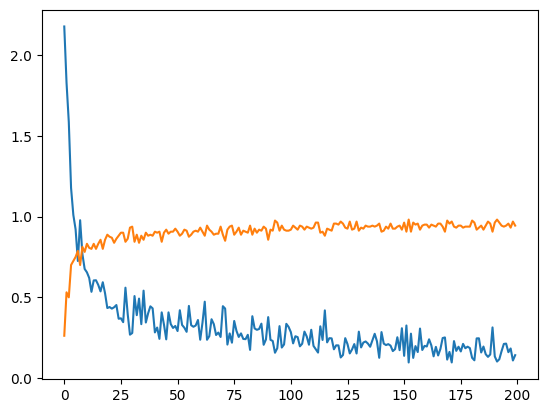

In [74]:
plt.plot(np.array(losses).reshape(-1, 5).mean(1))
plt.plot(np.array(accuracies).reshape(-1, 5).mean(1))

In [75]:
def evaluate(W1, W2):
  # forward pass test set
  z = X_test @ W1 # first pre activation
  a = np.maximum(0, z) # relu activation
  logits = a @ W2 # second hidden layer
  # apply log softmax
  logit_maxs = np.max(logits, axis=1, keepdims=True)
  norm_logits = logits - logit_maxs # prevent the overflow and infs
  counts = np.exp(norm_logits)
  counts_sum = np.sum(counts, axis=1, keepdims=True)
  counts_sum_inv = counts_sum ** -1
  probs = counts * counts_sum_inv
  test_logprobs = np.log(probs)
  return test_logprobs
test_logprobs = evaluate(W1, W2)
(np.argmax(test_logprobs, axis=1) == y_test).mean()

0.9472

The number is  9


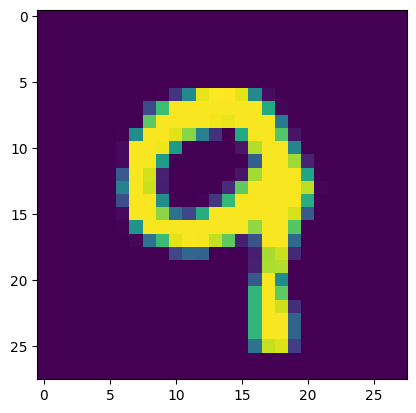

In [76]:
# inference
s = 99
plt.imshow(X_test[s].reshape(28, 28))
print("The number is ", np.argmax(test_logprobs[s]))

In [77]:
# forward pass

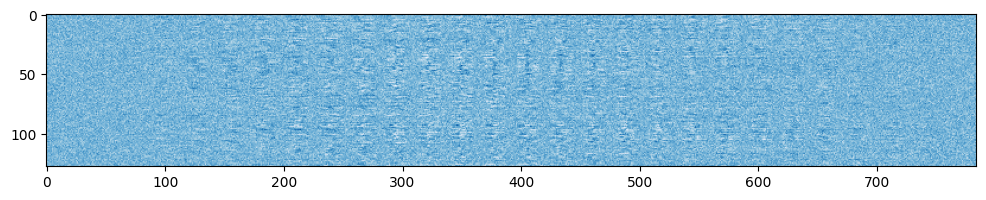

In [78]:
plt.figure(figsize=(12, 3))
plt.imshow(W1.T, cmap='Blues')

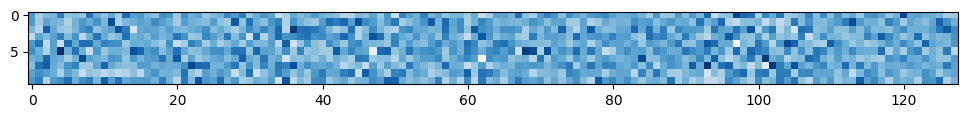

In [79]:
plt.figure(figsize=(12, 3))
plt.imshow(W2.T, cmap="Blues")

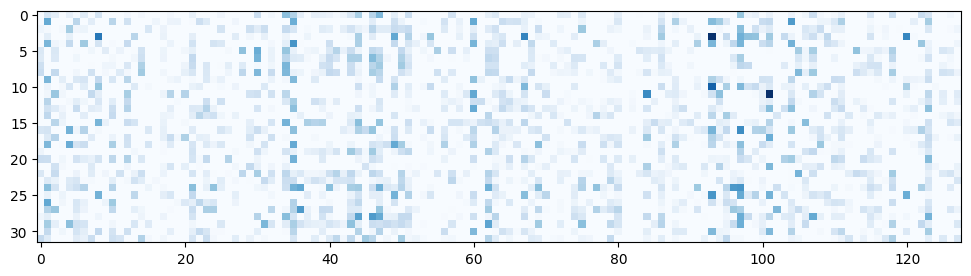

In [80]:
plt.figure(figsize=(12, 3))
plt.imshow(a, cmap='Blues')

In [81]:
(a == 0).sum() / a.size # firing rate

0.58251953125

In [82]:
# TODO:
# calculate the derivative of the log likelihood shorter way.
# we want to get `dlogits` shorter way
dlogits.shape

(32, 10)

In [83]:
# backward pass till `dlogits`
dloss = 1
dlogprobs = np.zeros_like(logprobs) * dloss
dlogprobs[range(n), ys] = -1.0 / n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(axis=1, keepdims=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
dcounts += np.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits2 = dnorm_logits.copy()
dlogit_maxs = (-dnorm_logits).sum(axis=1, keepdims=True)
dlogits2 += np.eye(logits.shape[1])[np.argmax(logits, axis=1)] * dlogit_maxs

In [84]:
# we want dlogits2 to be same dlogits but shorter way 
(dlogits == dlogits2).all()

True